In [1]:
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
data_dir = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0"
batch_size = 32

In [3]:
print(f"Training data: {len(os.listdir(os.path.join(data_dir, 'train', 'train-org-img')))}")
print(f"Validation data: {len(os.listdir(os.path.join(data_dir, 'val', 'val-org-img')))}")
print(f"Test data: {len(os.listdir(os.path.join(data_dir, 'test', 'test-org-img')))}")

Training data: 1445
Validation data: 450
Test data: 448


In [4]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, shift_limit=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(p=0.3),
    A.HueSaturationValue(p=0.3)
], additional_targets={'mask': 'mask'})

def apply_augmentation(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [5]:
def to_RGB(label):
    label_seg = np.zeros((*label.shape, 3), dtype=np.uint8)  # Create a 3-channel RGB array
    for key, val in class_map.items():
        # Find where the mask is equal to the current class value
        label_seg[label == val] = color_map[key]
    return label_seg


def display_images_with_masks(image, mask):
    print("Image shape:", image.shape)
    print("Mask shape:", to_RGB(mask).shape)

    plt.figure(figsize=(16, 14))
    
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(mask))

    plt.legend(handles, labels, bbox_to_anchor=(-0.8, -0.5), loc='lower center', ncol=5)
    plt.show()

Image shape: (3000, 4000, 3)
Mask shape: (3000, 4000, 3)


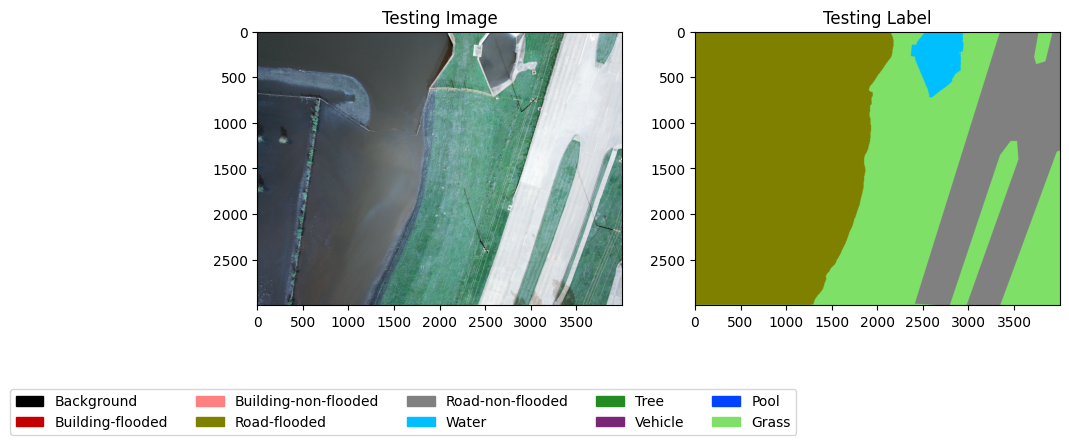

Image shape: (3000, 4000, 3)
Mask shape: (3000, 4000, 3)


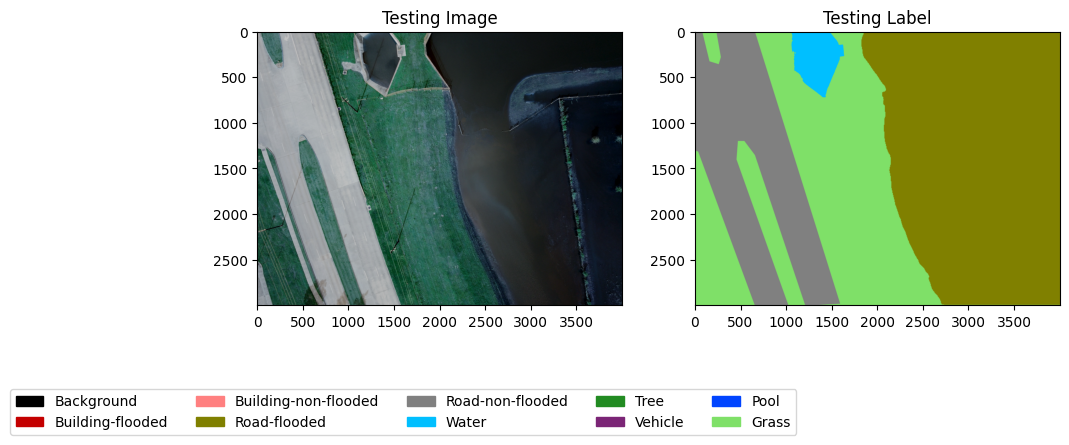

In [36]:
# Sample Usage
image = cv2.imread(f'{data_dir}/train/train-org-img/8206.jpg')
mask = cv2.imread(f'{data_dir}/train/train-label-img/8206.png', cv2.IMREAD_GRAYSCALE)

display_images_with_masks(image, mask)

augmented_image, augmented_mask = apply_augmentation(image, mask)
display_images_with_masks(augmented_image, augmented_mask)

In [6]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def calculate_label_image_count(base_dir, subsets):
    """
    Calculate the number of images each label appears in across specified subsets of a dataset.

    Args:
    base_dir (str): The base directory where the dataset is stored.
    subsets (list): A list of subsets of the dataset to analyze ('train', 'test', 'val').

    Returns:
    dict: A dictionary with class names as keys and the number of images they appear in as values.
    """
    label_names = {
        0: 'Background', 1: 'Building (flooded)', 2: 'Building (non-flooded)',
        3: 'Road (flooded)', 4: 'Road (non-flooded)', 5: 'Water', 6: 'Tree',
        7: 'Vehicle', 8: 'Pool', 9: 'Grass'
    }

    # Initialize dictionary to count image appearances for each label across all subsets
    label_image_count = {name: 0 for name in label_names.values()}

    # Process each subset and count labels
    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        # Track labels found in each image to avoid double counting for the same image
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                # Update image count for each unique label found in this mask
                for label in unique_labels:
                    if label in label_names:
                        label_image_count[label_names[label]] += 1

    return label_image_count

In [63]:
# Example usage
subsets = ['train', 'test', 'val']  
image_count_across_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_dataset)

  0%|          | 0/1445 [00:00<?, ?it/s]

100%|██████████| 450/450 [01:57<00:00,  3.83it/s]

{'Background': 172, 'Building (flooded)': 245, 'Building (non-flooded)': 880, 'Road (flooded)': 264, 'Road (non-flooded)': 1175, 'Water': 1059, 'Tree': 1882, 'Vehicle': 813, 'Pool': 531, 'Grass': 2161}


In [64]:
for key, value in image_count_across_dataset.items():
    print(f"{key:20} : {value}")

Background           : 172
Building (flooded)   : 245
Building (non-flooded) : 880
Road (flooded)       : 264
Road (non-flooded)   : 1175
Water                : 1059
Tree                 : 1882
Vehicle              : 813
Pool                 : 531
Grass                : 2161


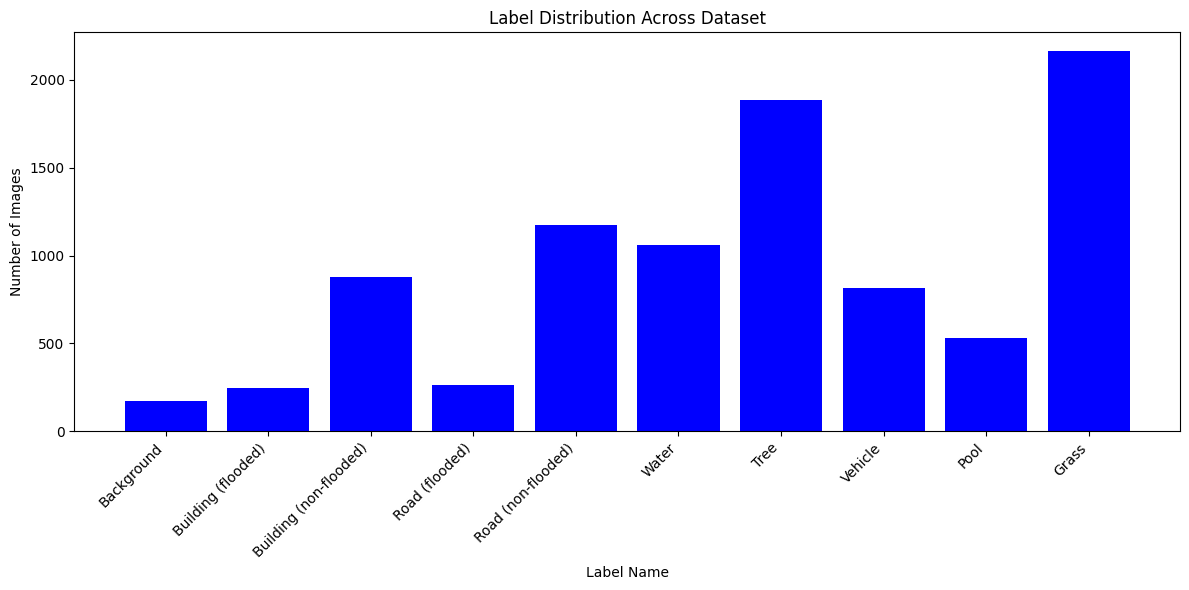

In [66]:
#create a bar graph to show the distribution of the labels across the dataset
import matplotlib.pyplot as plt

def plot_label_distribution(label_counts, title):
    """
    Plot a bar graph showing the distribution of labels across the dataset.

    Args:
    label_counts (dict): A dictionary with class names as keys and their counts as values.
    title (str): The title of the plot.
    """
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='blue')
    plt.xlabel('Label Name')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_dataset, 'Label Distribution Across Overall Dataset')

In [67]:
# Example usage
subsets = ['train']  
image_count_across_train_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_train_dataset)

100%|██████████| 1445/1445 [06:08<00:00,  3.92it/s]

{'Background': 98, 'Building (flooded)': 149, 'Building (non-flooded)': 540, 'Road (flooded)': 162, 'Road (non-flooded)': 711, 'Water': 668, 'Tree': 1156, 'Vehicle': 496, 'Pool': 331, 'Grass': 1331}


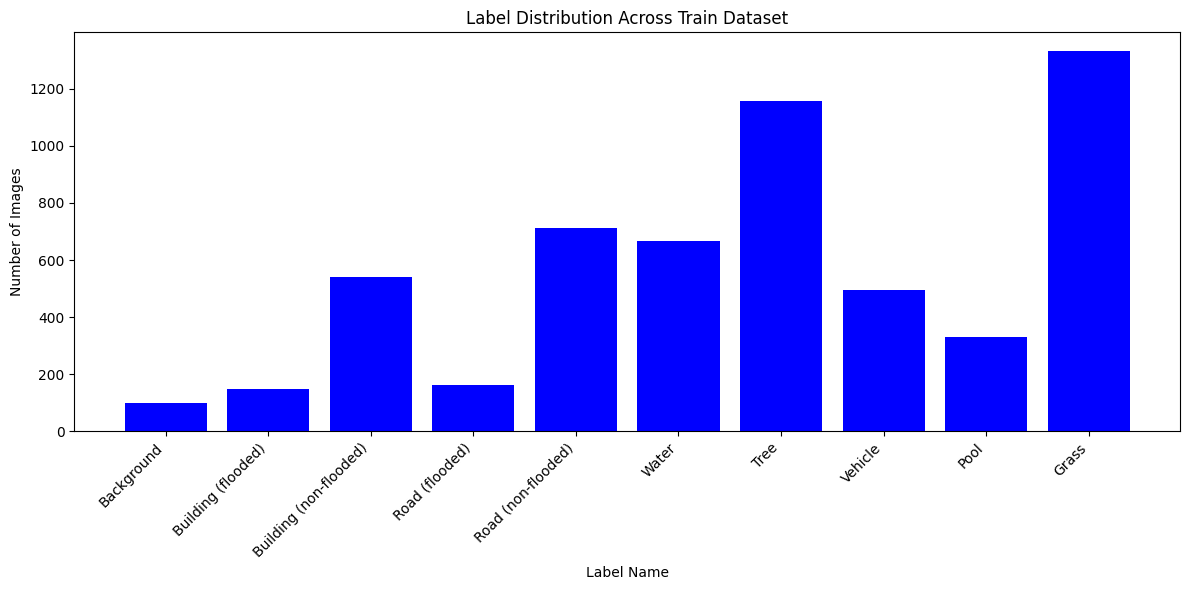

In [72]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_train_dataset, 'Label Distribution Across Train Dataset')

In [69]:
# Example usage
subsets = ['test']  
image_count_across_test_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_test_dataset)

100%|██████████| 448/448 [01:55<00:00,  3.88it/s]

{'Background': 40, 'Building (flooded)': 47, 'Building (non-flooded)': 173, 'Road (flooded)': 49, 'Road (non-flooded)': 234, 'Water': 183, 'Tree': 364, 'Vehicle': 166, 'Pool': 96, 'Grass': 414}


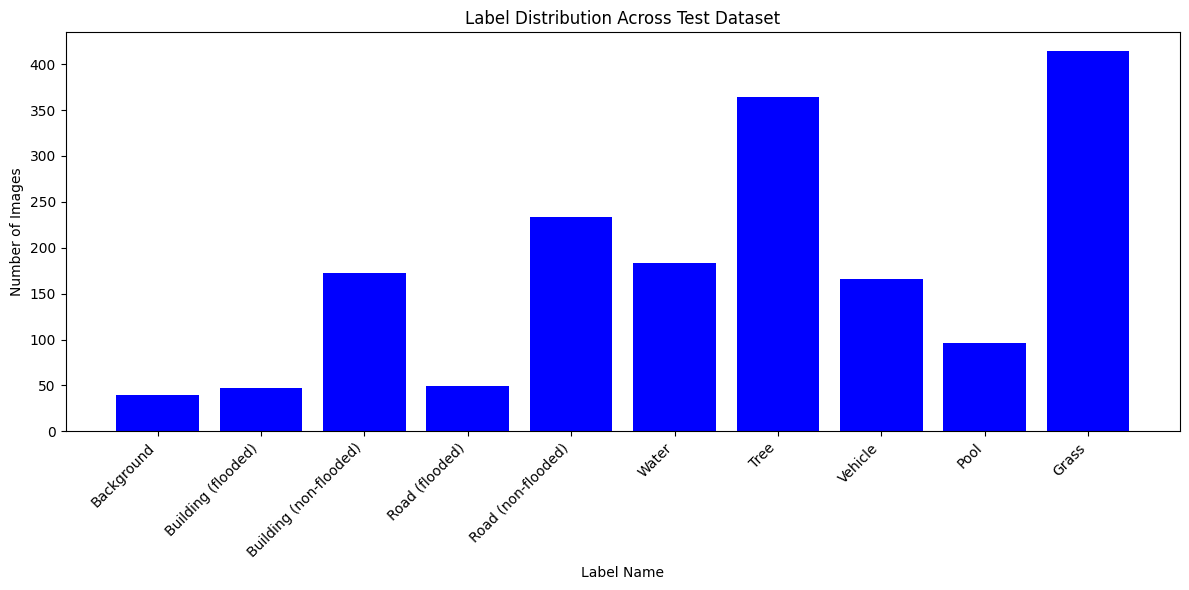

In [70]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_test_dataset, 'Label Distribution Across Test Dataset')

In [75]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def calculate_label_image_count_with_filter(base_dir, subsets, filter_labels):
    """
    Calculate the number of images each label appears in across specified subsets of a dataset.

    Args:
    base_dir (str): The base directory where the dataset is stored.
    subsets (list): A list of subsets of the dataset to analyze ('train', 'test', 'val').

    Returns:
    dict: A dictionary with class names as keys and the number of images they appear in as values.
    """
    label_names = {
        0: 'Background', 1: 'Building (flooded)', 2: 'Building (non-flooded)',
        3: 'Road (flooded)', 4: 'Road (non-flooded)', 5: 'Water', 6: 'Tree',
        7: 'Vehicle', 8: 'Pool'
    }

    # Initialize dictionary to count image appearances for each label across all subsets
    label_image_count = {name: 0 for name in label_names.values()}

    # Process each subset and count labels
    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        # Track labels found in each image to avoid double counting for the same image
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                #if image contains any of the filter labels, skip it
                if any(label in filter_labels for label in unique_labels):
                    continue
                
                # Update image count for each unique label found in this mask
                for label in unique_labels:
                    if label in label_names:
                        label_image_count[label_names[label]] += 1

    return label_image_count

# Example usage
subsets = ['train']  
image_count_across_train_dataset_without_grass_contained_images = calculate_label_image_count_with_filter(data_dir, subsets, filter_labels=[9])
print(image_count_across_train_dataset_without_grass_contained_images)

  0%|          | 0/1445 [00:00<?, ?it/s]

100%|██████████| 1445/1445 [05:57<00:00,  4.04it/s]

{'Background': 30, 'Building (flooded)': 58, 'Building (non-flooded)': 44, 'Road (flooded)': 60, 'Road (non-flooded)': 32, 'Water': 98, 'Tree': 102, 'Vehicle': 71, 'Pool': 54}


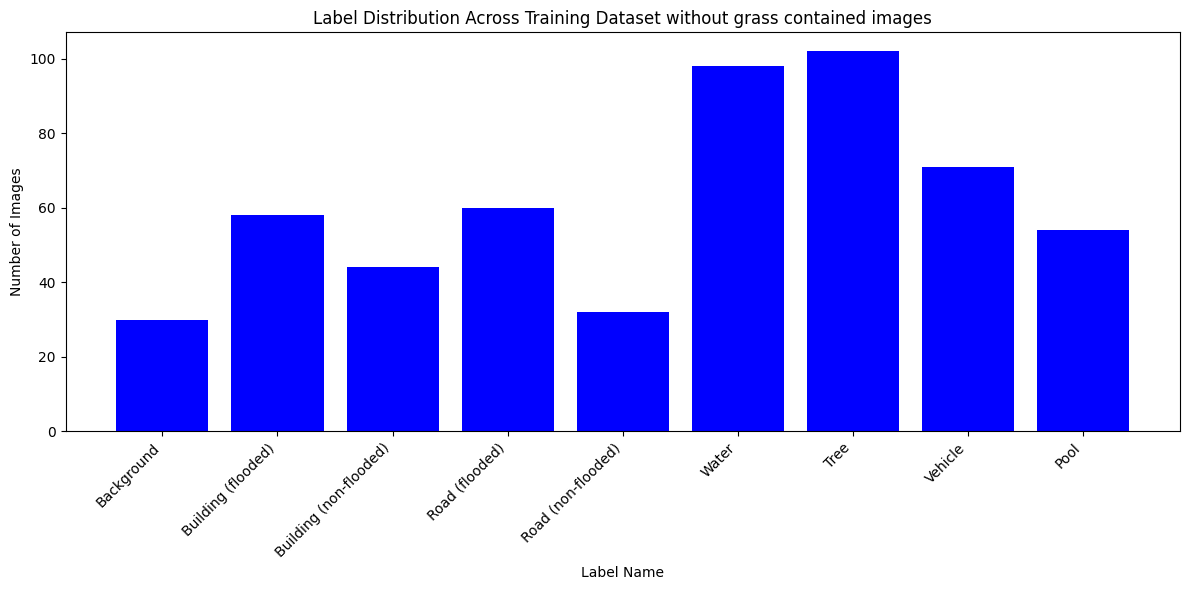

In [76]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_train_dataset_without_grass_contained_images, 'Label Distribution Across Training Dataset without grass contained images')

### Extracting those label paths which has no any grass inside in the scene

In [79]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def extract_images_paths(base_dir, subsets, filter_labels):
    paths = []

    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                if any(label in filter_labels for label in unique_labels):
                    continue
                
                paths.append(filepath)

    return paths

subsets = ['train']  
grass_excluded_images = extract_images_paths(data_dir, subsets, filter_labels=[9])
print(grass_excluded_images)

100%|██████████| 1445/1445 [06:09<00:00,  3.91it/s]

['E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10165.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10166.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\6442.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\6486.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7239.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7242.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7243.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7244.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7245.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7247.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7251.png', 'E:\\Se

In [80]:
len(grass_excluded_images)

114

In [7]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def extract_images_paths(base_dir, subsets, filter_labels):
    paths = []

    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                if any(label in filter_labels for label in unique_labels):
                    continue
                
                paths.append(filepath)

    return paths

subsets = ['train']  
trees_grass_excluded_images = extract_images_paths(data_dir, subsets, filter_labels=[6, 9])
print(trees_grass_excluded_images)

100%|██████████| 1445/1445 [07:01<00:00,  3.43it/s]

['E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10165.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10166.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\6486.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7746.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7756.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9026.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9027.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9028.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9029.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9030.png', 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\9033.png', 'E:\\Se

In [8]:
len(trees_grass_excluded_images)

12

## Actual Augmentation Code

In [205]:
import albumentations as A
import numpy as np
import random

def augment_image_mask(image, mask, num_augmented_images, 
                       flip_probs=[0.5, 0.5], 
                       rotate_probs=[0.5], rotate_limits=[(-45, 45)], 
                       scale_limits=[(0.9, 1.1)], shift_limits=[(-0.1, 0.1)], 
                       brightness_contrast_probs=[0.5], 
                       blur_probs=[0.3], 
                       hue_saturation_probs=[0.3]):
    
    augmented_images = []
    augmented_masks = []
    
    for _ in range(num_augmented_images):
        # Randomly select values from the provided arrays
        horizontal_flip_prob = np.random.choice(flip_probs)
        vertical_flip_prob = np.random.choice(flip_probs)
        rotate_prob = np.random.choice(rotate_probs)
        rotate_limit = random.choice(rotate_limits)
        scale_limit = random.choice(scale_limits)
        shift_limit = random.choice(shift_limits)
        brightness_contrast_prob = np.random.choice(brightness_contrast_probs)
        blur_prob = np.random.choice(blur_probs)
        hue_saturation_prob = np.random.choice(hue_saturation_probs)

        # Define the augmentation pipeline with selected values
        augmentation_pipeline = A.Compose([
            A.HorizontalFlip(p=horizontal_flip_prob),
            A.VerticalFlip(p=vertical_flip_prob),
            A.RandomRotate90(p=rotate_prob),
            A.ShiftScaleRotate(scale_limit=scale_limit, rotate_limit=rotate_limit, shift_limit=shift_limit, p=0.5),
            A.RandomBrightnessContrast(p=brightness_contrast_prob),
            A.Blur(p=blur_prob),
            A.HueSaturationValue(p=hue_saturation_prob)
        ], additional_targets={'mask': 'mask'})

        # Apply the augmentation
        augmented = augmentation_pipeline(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])
        
    return augmented_images, augmented_masks

Image shape: (3000, 4000, 3)
Mask shape: (3000, 4000, 3)


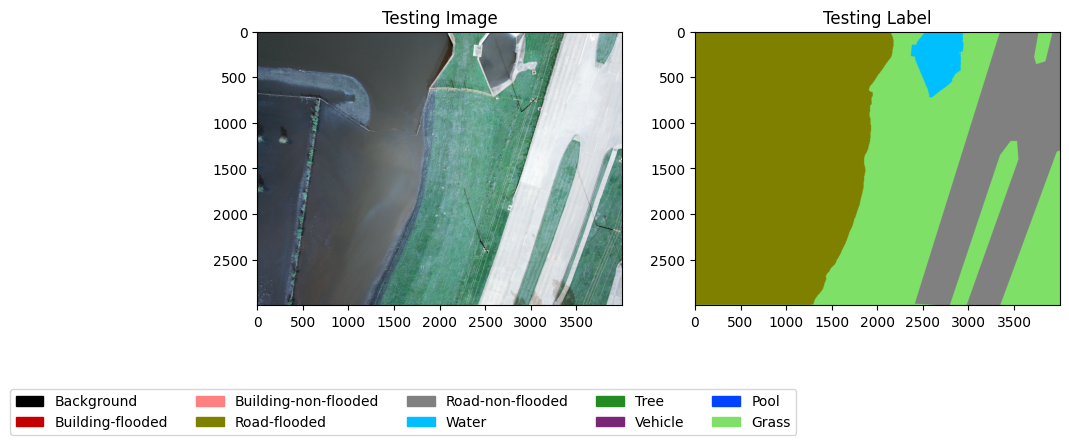

Image shape: (4000, 3000, 3)
Mask shape: (4000, 3000, 3)


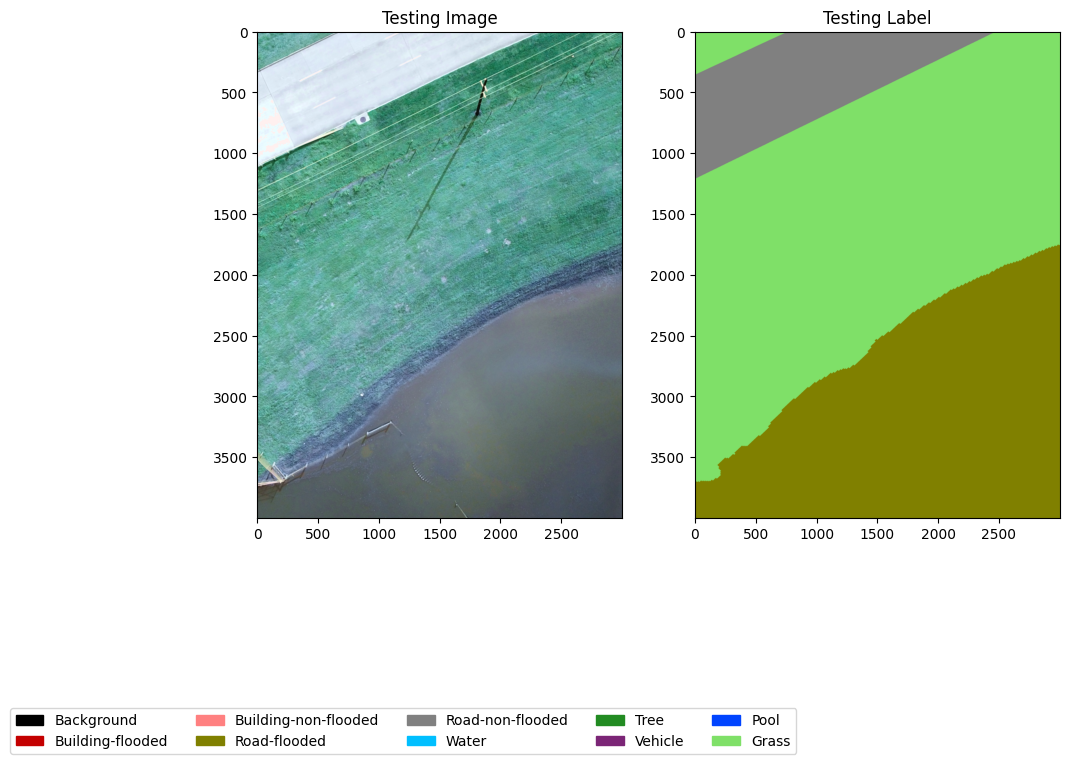

In [171]:
# Sample Usage
image = cv2.imread(f'{data_dir}/train/train-org-img/8206.jpg')
mask = cv2.imread(f'{data_dir}/train/train-label-img/8206.png', cv2.IMREAD_GRAYSCALE)

display_images_with_masks(image, mask)

no_augment = 1
agm_images, agm_masks = augment_image_mask(image, mask, num_augmented_images=no_augment)
for i in range(no_augment):
    display_images_with_masks(agm_images[i], agm_masks[i])

In [89]:
grass_excluded_images

['E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10165.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\10166.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\6442.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\6486.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7239.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7242.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7243.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7244.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7245.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7247.png',
 'E:\\Segmentation\\datasets\\FloodNet-Supervised_v1.0\\train\\train-label-img\\7251.png

In [216]:
import os
import cv2
from tqdm import tqdm

def augment_images(paths, output_dir, num_augmented_images):
    if not os.path.exists(os.path.join(output_dir, 'train-org-aug-img')):
        os.makedirs(os.path.join(output_dir, 'train-org-aug-img'))
    if not os.path.exists(os.path.join(output_dir, 'train-label-aug-img')):
        os.makedirs(os.path.join(output_dir, 'train-label-aug-img'))

    for label_path in tqdm(paths):
        actual_image_path = label_path.replace('label-img', 'org-img').replace('.png', '.jpg')

        image = cv2.imread(actual_image_path)
        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        # Augment the image and mask
        augmented_images, augmented_masks = augment_image_mask(image, mask, num_augmented_images)
        
        # Save the augmented images and masks
        for i in range(len(augmented_images)):
            image_name = os.path.basename(label_path).replace('.png', f'_aug_{i}.jpg')
            mask_name = os.path.basename(label_path).replace('.png', f'_aug_{i}.png')

            image_path = os.path.join(output_dir, 'train-org-aug-img', image_name)
            mask_path = os.path.join(output_dir, 'train-label-aug-img', mask_name)
            
            cv2.imwrite(image_path, augmented_images[i])
            cv2.imwrite(mask_path, augmented_masks[i])

In [217]:
augmented_images_dir = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\train"
augment_images(grass_excluded_images, augmented_images_dir, num_augmented_images=3)

100%|██████████| 114/114 [03:50<00:00,  2.02s/it]


Image shape: (4592, 3072, 3)
Mask shape: (4592, 3072, 3)


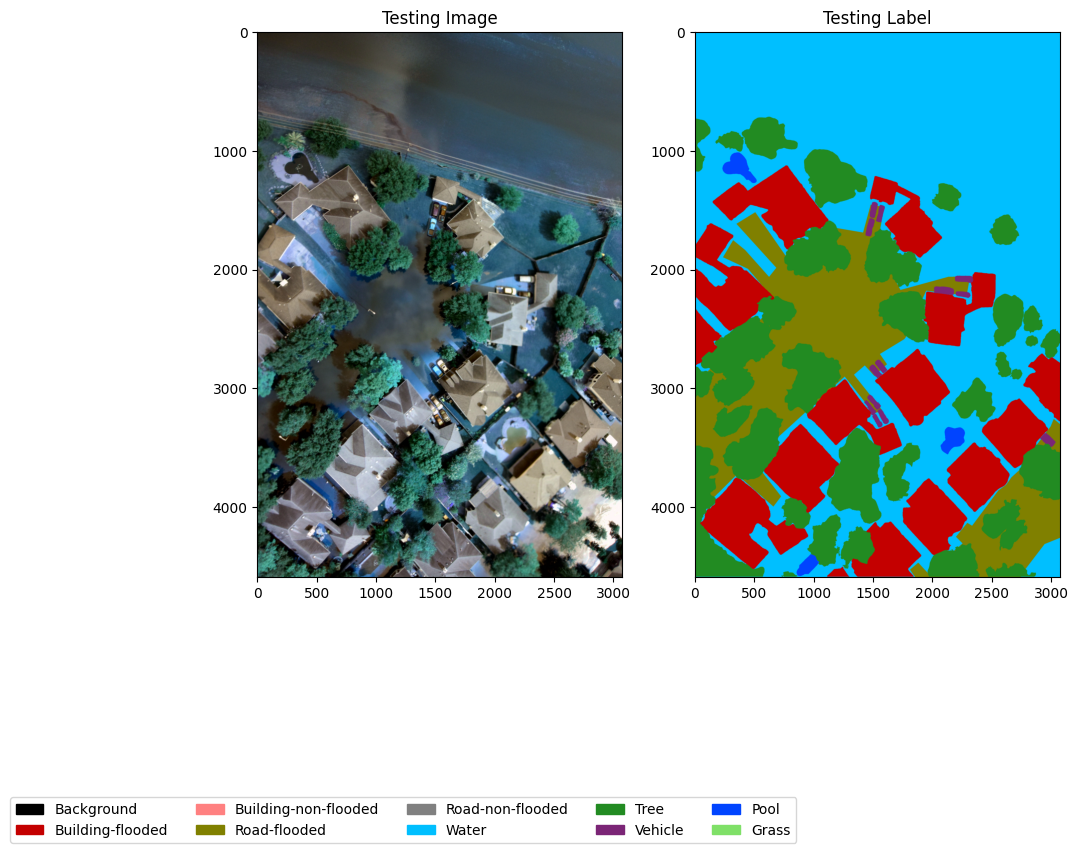

In [219]:
#"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\train\train-org-aug-img\6442_aug_1.jpg"
image = cv2.imread(r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0\train\train-org-aug-img\7244_aug_2.jpg', cv2.IMREAD_COLOR)
mask = cv2.imread(r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0\train\train-label-aug-img\7244_aug_2.png', cv2.IMREAD_GRAYSCALE)

display_images_with_masks(image, mask)

In [220]:
subsets = ['train']  
image_count_across_dataset = calculate_label_image_count(r'E:\Segmentation\datasets\temp', subsets)
print(image_count_across_dataset)

100%|██████████| 1787/1787 [07:53<00:00,  3.77it/s]

{'Background': 185, 'Building (flooded)': 306, 'Building (non-flooded)': 649, 'Road (flooded)': 335, 'Road (non-flooded)': 801, 'Water': 949, 'Tree': 1431, 'Vehicle': 677, 'Pool': 459, 'Grass': 1331}


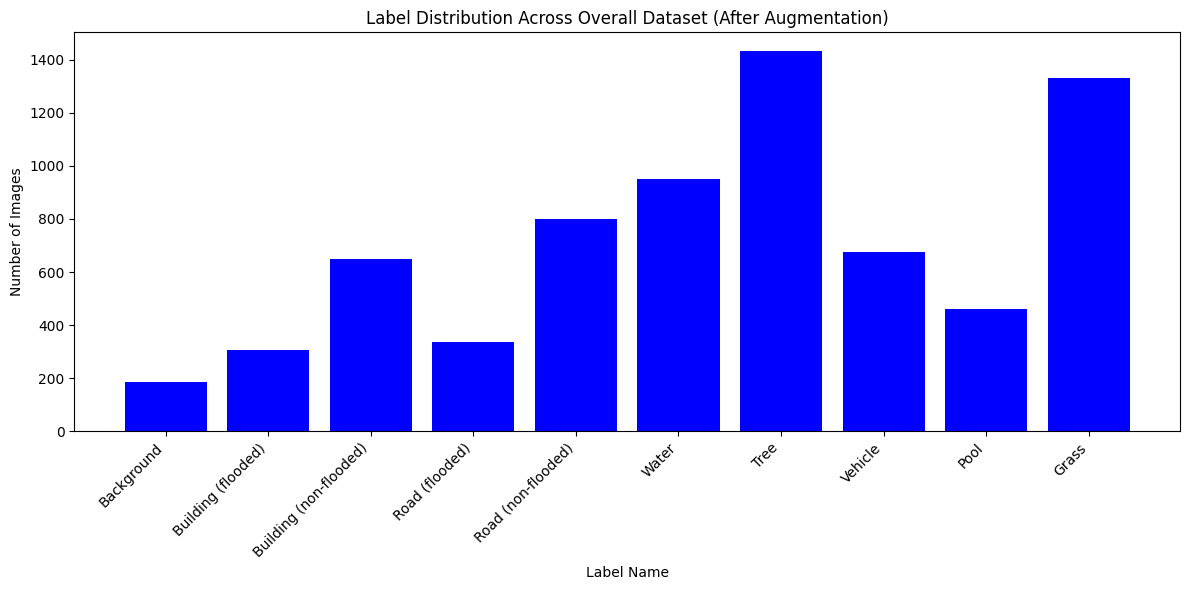

In [221]:
plot_label_distribution(image_count_across_dataset, 'Label Distribution Across Overall Dataset (After Augmentation)')